In [72]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

Neural Network Model for Hyper Parameter Tuning

In [73]:
def benchmark(X, Y):
    return -((1.5 - X + X * Y)**2 + (2.25 - X + X * Y**2)**2 + (2.625 - X + X * Y**3)**2)


In [74]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [75]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [76]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-4.5, 4.5, 5)
Y = np.random.uniform(-4.5, 4.5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [77]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [78]:
df

,x,y,z
0,-0.746802,-3.668953,-1695.133401
1,1.982920,-2.823658,-2231.461373
2,-4.498971,-1.389953,-522.757847
3,-1.779007,-0.929093,-64.660164
4,-3.179197,0.349351,-70.191649


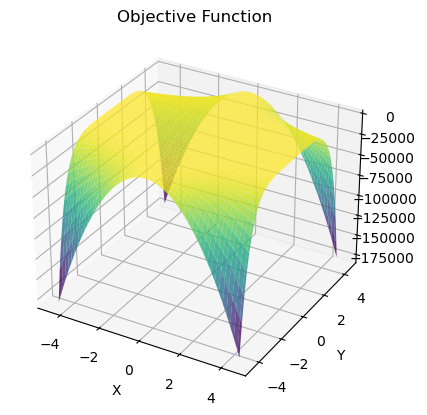

In [79]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-4.5, 4.5, 100)
y_range = np.linspace(-4.5, 4.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [80]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [81]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3, "Y":  0.5, "Z": benchmark( 3,  0.5)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

,X,Y,Z
0,3,0.5,-0.0


In [82]:
def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
    {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.32360766 -2.98273191]


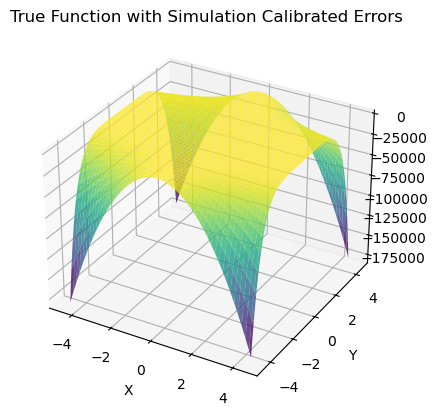

In [83]:
# Create the grid of input values
x_range = np.linspace(-4.5, 4.5, 100)
y_range = np.linspace(-4.5, 4.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [84]:
x1_range = np.linspace(-4.5, 4.5, 100)
x2_range = np.linspace(-4.5, 4.5, 100)
bounds = np.array([[-4.5, 4.5], [-4.5, 4.5]])  # Bounds for x1 and x2

# Generate 15 points using Latin Hypercube Sampling (LHS)
n_samples = 15
lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
lhs_samples = lhs.random(n=n_samples)

scaled_samples = qmc.scale(lhs_samples, bounds[:, 0], bounds[:, 1])

selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

sim_df = df[["x", "y", "sim_z"]]
sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)

In [85]:
# Define the objective function to minimize
@use_named_args(hyp_space)
def objective(**params):
    num_layers = params['num_layers']
    num_units = params['num_units']
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    model = NN_model(num_layers, num_units, learning_rate, dropout_rate)

    # Define K-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []

    # Perform cross-validation
    for train_idx, val_idx in kfold.split(sim_df[['x', 'y']]):
        X_train, X_val = sim_df[['x', 'y']].iloc[train_idx], sim_df[['x', 'y']].iloc[val_idx]
        y_train, y_val = sim_df[['sim_z']].iloc[train_idx], sim_df[['sim_z']].iloc[val_idx]

        # Standardize the features
        scaler_x = StandardScaler().fit(X_train)
        X_train_scaled = scaler_x.transform(X_train)
        X_val_scaled = scaler_x.transform(X_val)

        # Train the model
        model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

        # Evaluate the model
        score = model.evaluate(X_val_scaled, y_val, verbose=0)
        scores.append(score)

    return np.mean(scores)

# Perform Bayesian optimization
result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

# Output best hyperparameters from BayesOpt
print("Best hyperparameters:")
print("num_layers:", result.x[0])
print("num_units:", result.x[1])
print("learning_rate:", result.x[2])
print("dropout_rate:", result.x[3])
print("batch_size:", result.x[4])
print("epochs:", result.x[5])

# Train the model with the best hyperparameters on the entire dataset
best_model = NN_model(
    num_layers=result.x[0],
    num_units=result.x[1],
    learning_rate=result.x[2],
    dropout_rate=result.x[3]
)


Best hyperparameters:
num_layers: 7
num_units: 200
learning_rate: 0.001702211209278648
dropout_rate: 0.5
batch_size: 20
epochs: 200


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 50020496.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 50018728.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 50016940.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 50016584.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 50011508.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 50010580.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 50006272.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 49992868.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 49980312.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 49955844.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 49946920.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 49876240.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 49863740.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 497

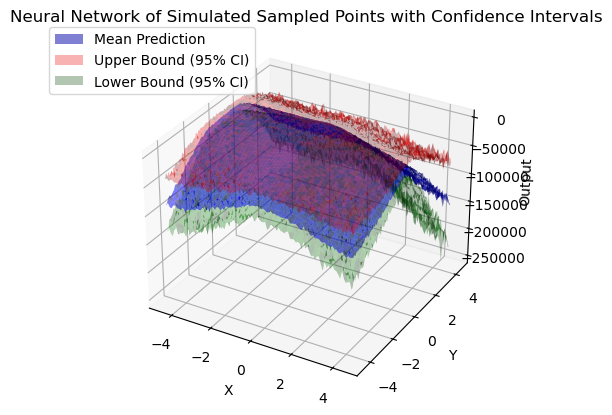

In [86]:
# Standardize the combined datasets
scaler_x = StandardScaler().fit(sim_df[['x', 'y']])
X_scaled = scaler_x.transform(sim_df[['x', 'y']])

# Train the best model on the combined standardized dataset
best_model.fit(X_scaled, sim_df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

# Create a meshgrid and combine into a single array
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

# Perform MC Dropout predictions on the entire grid
pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

# Ploting mean predictions and confidence intervals
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Reshaping predictions back to grid shape
pred_mean_grid = pred_mean.reshape(x1_grid.shape)
pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

# Customize the plot
ax.set_title('Neural Network of Simulated Sampled Points with Confidence Intervals')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Output')

# Legend
legend_elements = [mean_surface, upper_surface, lower_surface]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()

In [90]:
x_range = [(-4.5, 4.5)]
y_range = [(-4.5, 4.5)]

In [ ]:
def p_nn(xy):
    xy = np.array(xy).reshape(1, -1)  # Ensure correct shape (1,2)
    
    # Check if the point is inside the valid domain
    if not (x_range[0][0] <= xy[0, 0] <= x_range[0][1] and 
            y_range[0][0] <= xy[0, 1] <= y_range[0][1]):
        return 0  # Reject the point by setting probability to 0

    pred_mean, pred_std = mc_dropout_predictions(best_model, xy)  # Get mean & uncertainty

    # Compute probability proportional to NN's UCB
    p_value = max(pred_mean + 1.96 * pred_std - sim_df["sim_z"].median(), 0)
    
    return p_value


def metropolis_step(xy, sig):
    prop_xy = xy + np.random.normal(0, sig, size=xy.shape)  # Generate a candidate
    prop_xy = np.clip(prop_xy, x_range[0][0], x_range[0][1])  # Keep inside bounds

    # Ensure proposed point is inside the valid bounds
    if not (x_range[0][0] <= prop_xy[0, 0] <= x_range[0][1] and 
            y_range[0][0] <= prop_xy[0, 1] <= y_range[0][1]):
        return xy  # Reject out-of-bounds proposals

    u = np.random.uniform(0, 1)
    if u < min(1.0, p_nn(prop_xy) / p_nn(xy)):
        return prop_xy  # Accept move
    else:
        return xy  # Stay at current point


def mh_sampler(sig, sample_size, burn_in, lag):
    # Start at the point with the largest simulated response
    max_idx = np.argmax(sim_df["sim_z"])
    x_init = sim_df["x"].iloc[max_idx]
    y_init = sim_df["y"].iloc[max_idx]
    xy = np.array([[x_init, y_init]])

    # Burn-in phase
    for i in range(burn_in):
        xy = metropolis_step(xy, sig)

    # Sampling phase
    output = xy
    for i in range(sample_size - 1):
        for j in range(lag):
            xy = metropolis_step(xy, sig)
        output = np.vstack((output, xy))  # Stack valid samples

    return output  # Returns an array of shape (sample_size, 2)


# Use Metropolis-Hastings to sample new experimental points
X_mh = mh_sampler(sig=7, sample_size=5, burn_in=300, lag=30)

# Convert MH samples to a DataFrame
physical_test_points = pd.DataFrame(X_mh, columns=["x", "y"])

In [93]:
physical_test_points

,x,y
0,-4.083782,0.864707
1,-3.082532,0.441270
2,-3.082532,0.441270
3,-1.834668,0.095674
4,-2.231100,0.597906


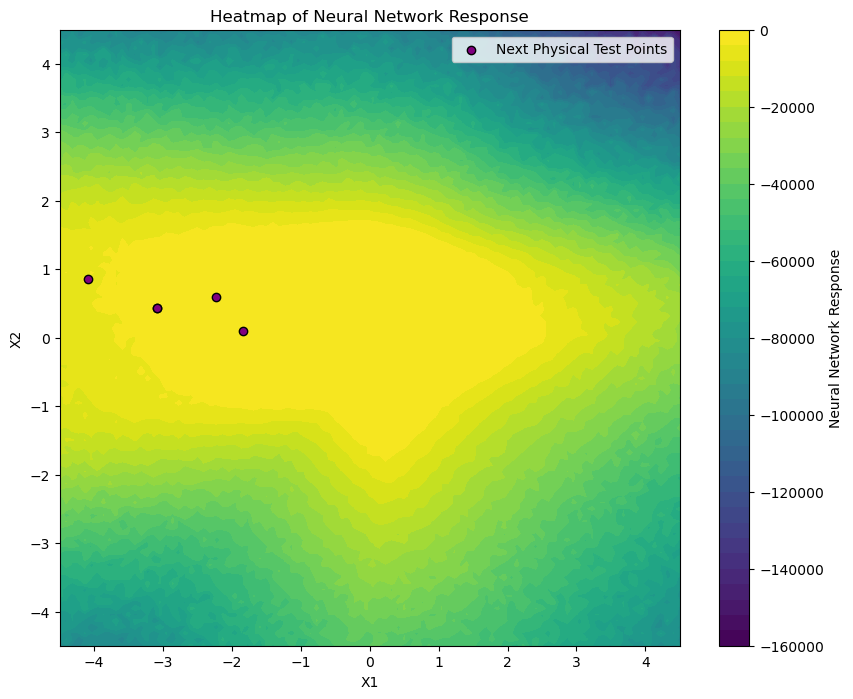

In [94]:
# Generate predictions for the heatmap
pred_mean_grid = pred_mean.reshape(x1_grid.shape)

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.contourf(x1_grid, x2_grid, pred_mean_grid, cmap='viridis', levels=50)
plt.colorbar(heatmap, label="Neural Network Response")

# Overlay sampled points
#plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

# Customize the plot
plt.title("Heatmap of Neural Network Response")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

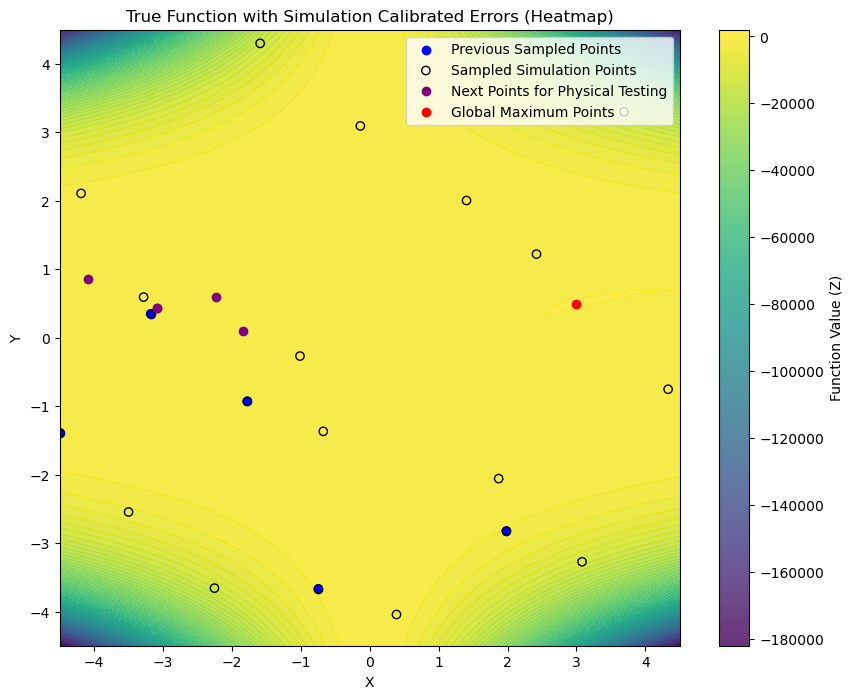

In [96]:
# Add validated data points to original data frame
physical_test_points["z"] = benchmark(physical_test_points['x'], physical_test_points['y']) + ran_err(5, 0.05)
physical_test_points["a"] = bo.x_opt[0]
physical_test_points["b"] = bo.x_opt[1]
physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

# Heatmap of Simulated Points 
fig, ax = plt.subplots(figsize=(10, 8))


x_range = np.linspace(-4.5, 4.5, 100)
y_range = np.linspace(-4.5, 4.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Points for Physical Testing')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [ ]:
df

,x,y,z,a,b,sim_z,diff
0,-0.746802,-3.668953,-1695.133401,4.323608,-2.982732,-1694.266005,-0.867396
1,1.982920,-2.823658,-2231.461373,4.323608,-2.982732,-2231.474423,0.013050
2,-4.498971,-1.389953,-522.757847,4.323608,-2.982732,-521.819231,-0.938616
3,-1.779007,-0.929093,-64.660164,4.323608,-2.982732,-64.195661,-0.464503
4,-3.179197,0.349351,-70.191649,4.323608,-2.982732,-69.863205,-0.328445


In [ ]:
physical_test_points

,x,y,z,a,b,sim_z,diff
0,-2.750108,0.637864,-43.103624,4.323608,-2.982732,-43.135550,0.031927
1,0.000000,0.000000,-14.197591,4.323608,-2.982732,-14.175896,-0.021695
2,0.000000,0.000000,-14.217217,4.323608,-2.982732,-14.175896,-0.041321
3,0.000000,0.000000,-14.224219,4.323608,-2.982732,-14.175896,-0.048322
4,0.000000,0.000000,-14.166246,4.323608,-2.982732,-14.175896,0.009651
5,-0.887819,0.229717,-26.522156,4.323608,-2.982732,-26.595365,0.073209
6,-4.599558,1.422479,-42.394583,4.323608,-2.982732,-42.724470,0.329887
7,-4.599558,1.422479,-42.428536,4.323608,-2.982732,-42.724470,0.295934
8,-4.599558,1.422479,-42.529854,4.323608,-2.982732,-42.724470,0.194616


In [ ]:
df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)
